<a href="https://colab.research.google.com/github/Followb1ind1y/D2L_Pytorch_Study_Notes/blob/main/14_D2L_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dive into Deep Learning 中文学习笔记** 
# **14. 计算机视觉（Computer Vision）**


## **14.1. 图像增广（Image Augmentation）**

在深度卷积神经网络里我们提到过，大规模数据集是成功应用深度神经网络的前提。**图像增广（*image augmentation*）** 技术通过对训练图像做一系列随机改变，来产生相似但又不同的训练样本，从而扩大训练数据集的规模。图像增广的另一种解释是，随机改变训练样本可以降低模型对某些属性的依赖，从而提高模型的泛化能力。例如，我们可以对图像进行不同方式的裁剪，使感兴趣的物体出现在不同位置，从而减轻模型对物体出现位置的依赖性。我们也可以调整亮度、色彩等因素来降低模型对色彩的敏感度。可以说，在当年AlexNet的成功中，图像增广技术功不可没。本节我们将讨论这个在计算机视觉里被广泛使用的技术。

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### **14.1.1. 常用的图像增广方法（Common Image Augmentation Methods）**

我们来读取一张形状为 $400×500$（高和宽分别为 400 像素和 500 像素）的图像作为实验的样例。

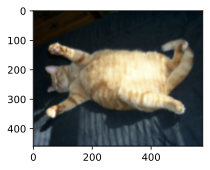

In [4]:
d2l.set_figsize()
img = d2l.Image.open('/content/cat1.jpg')
d2l.plt.imshow(img);

大部分图像增广方法都有一定的随机性。为了方便观察图像增广的效果，接下来我们定义一个辅助函数 `apply`。这个函数对输入图像img多次运行图像增广方法 `aug` 并展示所有的结果。

In [5]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

**14.1.1.1. 翻转和裁剪（Flipping and Cropping）**

左右翻转图像通常不改变物体的类别。它是最早也是最广泛使用的一种图像增广方法。下面我们通过 `torchvision.transforms` 模块创建 `RandomHorizontalFlip` 实例来实现一半概率的图像水平（左右）翻转。

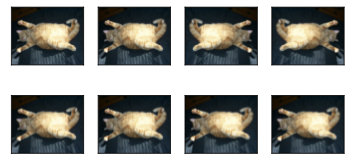

In [6]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

上下翻转不如左右翻转通用。但是至少对于样例图像，上下翻转不会造成识别障碍。下面我们创建 `RandomVerticalFlip` 实例来实现一半概率的图像垂直（上下）翻转。

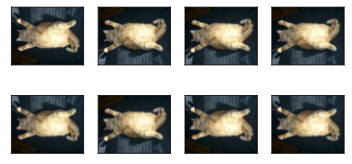

In [7]:
apply(img, torchvision.transforms.RandomVerticalFlip())

在我们使用的样例图像里，猫在图像正中间，但一般情况下可能不是这样。在池化层章节里我们解释了池化层能降低卷积层对**目标位置的敏感度**。除此之外，我们还可以通过对图像随机裁剪来让物体以不同的比例出现在图像的不同位置，这同样能够降低模型对目标位置的敏感性。

在下面的代码里，我们每次随机裁剪出一块面积为原面积 $10%∼100%$ 的区域，且该区域的宽和高之比随机取自 $0.5∼2$，然后再将该区域的宽和高分别缩放到 200 像素。

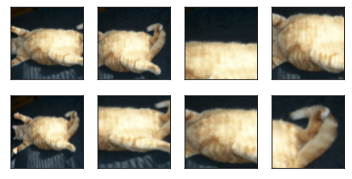

In [8]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

**14.1.1.2. 变化颜色（Changing Colors）**

另一类增广方法是变化颜色。我们可以从4个方面改变图像的颜色：亮度（`brightness`）、对比度（`contrast`）、饱和度（`saturation`）和色调（`hue`）。在下面的例子里，我们将图像的亮度随机变化为原图亮度的 $50%（1−0.5）∼150%（1+0.5）$。

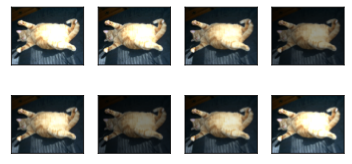

In [9]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

我们也可以随机变化图像的色调。

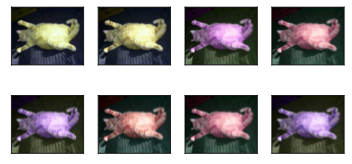

In [10]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

我们也可以同时设置如何随机变化图像的亮度（`brightness`）、对比度（`contrast`）、饱和度（`saturation`）和色调（`hue`）。

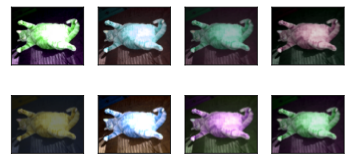

In [12]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

**14.1.1.3. 叠加多个图像增广方法（Combining Multiple Image Augmentation Methods）**

实际应用中我们会将多个图像增广方法叠加使用。我们可以通过 `Compose` 实例将上面定义的多个图像增广方法叠加起来，再应用到每张图像之上。

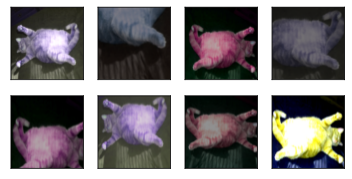

In [13]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

###**14.1.2. 使用图像增广训练模型（Training with Image Augmentation）**

下面我们来看一个将图像增广应用在实际训练中的例子。这里我们使用 CIFAR-10 数据集，而不是之前我们一直使用的 Fashion-MNIST 数据集。这是因为 Fashion-MNIST 数据集中物体的位置和尺寸都已经经过归一化处理，而 CIFAR-10 数据集中物体的颜色和大小区别更加显著。下面展示了 CIFAR-10 数据集中前 32 张训练图像。

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


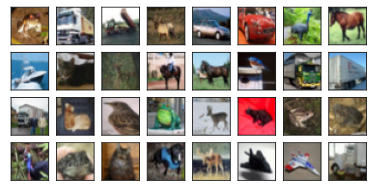

In [14]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

为了在预测时得到确定的结果，我们 **通常只将图像增广应用在训练样本上**，而不在预测时使用含随机操作的图像增广。在这里我们只使用最简单的随机左右翻转。此外，我们使用 ToTensor 将小批量图像转成 PyTorch 需要的格式，即形状为(批量大小, 通道数, 高, 宽)、值域在 0 到 1 之间且类型为 32 位浮点数。

In [15]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

接下来我们定义一个辅助函数来方便读取图像并应用图像增广。

In [16]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

## **14.2. 微调（Fine-Tuning）**

在前面的一些章节中，我们介绍了如何在只有 6 万张图像的 Fashion-MNIST 训练数据集上训练模型。我们还描述了学术界当下使用最广泛的大规模图像数据集 ImageNet，它有超过 1,000 万的图像和 1,000 类的物体。然而，我们平常接触到数据集的规模通常在这两者之间。

假设我们想从图像中识别出不同种类的椅子，然后将购买链接推荐给用户。一种可能的方法是先找出 100 种常见的椅子，为每种椅子拍摄 1,000 张不同角度的图像，然后在收集到的图像数据集上训练一个分类模型。这个椅子数据集虽然可能比 Fashion-MNIST 数据集要庞大，但样本数仍然不及 ImageNet 数据集中样本数的十分之一。这可能会导致适用于 ImageNet 数据集的复杂模型在这个椅子数据集上过拟合。同时，因为数据量有限，最终训练得到的模型的精度也可能达不到实用的要求。

为了应对上述问题，一个显而易见的解决办法是收集更多的数据。然而，收集和标注数据会花费大量的时间和资金。例如，为了收集 ImageNet 数据集，研究人员花费了数百万美元的研究经费。虽然目前的数据采集成本已降低了不少，但其成本仍然不可忽略。

另外一种解决办法是应用 **迁移学习（*transfer learning*）**，将从源数据集学到的知识迁移到目标数据集上。例如，虽然 ImageNet 数据集的图像大多跟椅子无关，但在该数据集上训练的模型可以**抽取较通用的图像特征，从而能够帮助识别边缘、纹理、形状和物体组成等**。这些类似的特征对于识别椅子也可能同样有效。

###**14.2.1. 步骤（Steps）**

本节我们介绍迁移学习中的一种常用技术：**微调（*fine tuning*）**。微调由以下 4 步构成。

1. 在源数据集（如 ImageNet 数据集）上预训练一个神经网络模型，即 **源模型（*source model*）**。
2. 创建一个新的神经网络模型，即 **目标模型（*target model*）**。它复制了**源模型上除了输出层外的所有模型设计及其参数**。我们假设这些模型参数包含了源数据集上学习到的知识，且这些知识同样适用于目标数据集。我们还假设源模型的输出层跟源数据集的标签紧密相关，因此在目标模型中不予采用。
3. 为目标模型添加一个输出大小为目标数据集类别个数的输出层，并随机初始化该层的模型参数。
4. 在目标数据集（如椅子数据集）上训练目标模型。我们将从头训练输出层，而其余层的参数都是基于源模型的参数微调得到的。

<center><img src="https://drive.google.com/uc?export=view&id=15hG_zwmfe4mG9VSbb9CSIswP3ySI_KW3" width=500px /></center>

当目标数据集远小于源数据集时，微调有助于提升模型的泛化能力。


###**14.2.2. 热狗识别（Hot Dog Recognition）**

接下来我们来实践一个具体的例子：热狗识别。我们将基于一个小数据集对在 ImageNet 数据集上训练好的 ResNet 模型进行微调。该小数据集含有数千张包含热狗和不包含热狗的图像。我们将使用微调得到的模型来识别一张图像中是否包含热狗。

In [2]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

**14.2.2.1. 获取数据集（Reading the Dataset）**

我们使用的热狗数据集是从网上抓取的，它含有 1400 张包含热狗的正类图像，和同样多包含其他食品的负类图像。各类的 1000 张图像被用于训练，其余则用于测试。

我们首先将压缩后的数据集下载到路径 `data_dir` 之下，然后在该路径将下载好的数据集解压，得到两个文件夹 h`otdog/train和hotdog/test`。这两个文件夹下面均有 `hotdog` 和 `not-hotdog` 两个类别文件夹，每个类别文件夹里面是图像文件。

In [3]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

我们创建两个 `ImageFolder` 实例来分别读取训练数据集和测试数据集中的所有图像文件。

In [4]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

下面画出前 8 张正类图像和最后 8 张负类图像。可以看到，它们的大小和高宽比各不相同。

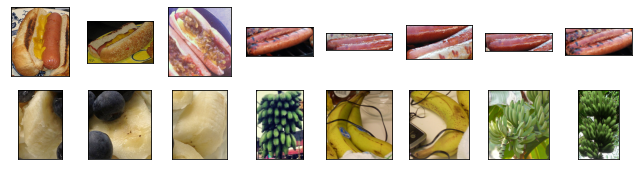

In [5]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

在训练时，我们先从图像中裁剪出随机大小和随机高宽比的一块随机区域，然后将该区域缩放为高和宽均为 224 像素的输入。测试时，我们将图像的高和宽均缩放为 256 像素，然后从中裁剪出高和宽均为 224 像素的中心区域作为输入。此外，我们对RGB（红、绿、蓝）三个颜色通道的数值做标准化：每个数值减去该通道所有数值的平均值，再除以该通道所有数值的标准差作为输出。

In [6]:
# Specify the means and standard deviations of the three RGB channels to
# standardize each channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

**14.2.2.2. 定义和初始化模型（Defining and Initializing the Model）**

我们使用在 ImageNet 数据集上预训练的 ResNet-18 作为源模型。这里指定 `pretrained=True` 来自动下载并加载预训练的模型参数。在第一次使用时需要联网下载模型参数。

In [7]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

下面打印源模型的成员变量 `fc`。作为一个全连接层，它将ResNet最终的全局平均池化层输出变换成 ImageNet 数据集上 1000 类的输出。

In [8]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

可见此时 `pretrained_net` 最后的输出个数等于目标数据集的类别数 1000。所以我们应该将最后的 `fc` 成修改我们需要的输出类别数。

此时，`pretrained_net` 的 `fc` 层就被随机初始化了，但是其他层依然保存着预训练得到的参数。由于是在很大的 `ImageNet` 数据集上预训练的，所以参数已经足够好，因此一般只需使用**较小的学习率**来微调这些参数，而 `fc` 中的随机初始化参数一般**需要更大的学习率从头训练**。PyTorch 可以方便的对模型的不同部分设置不同的学习参数，我们在下面代码中将 fc 的学习率设为已经预训练过的部分的10倍。

In [9]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

**14.2.2.3. 微调模型（Fine-Tuning the Model）**

我们先定义一个使用微调的训练函数 `train_fine_tuning` 以便多次调用。

In [10]:
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

我们将基础学习率设置为一个小值，以便对通过预训练获得的模型参数进行微调。基于之前的设置，我们将使用大十倍的学习率从头训练目标模型的输出层参数。

loss 0.219, train acc 0.920, test acc 0.925
297.0 examples/sec on [device(type='cuda', index=0)]


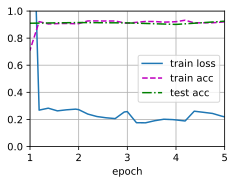

In [11]:
train_fine_tuning(finetune_net, 5e-5)

为了比较，我们定义了一个相同的模型，但将其所有的模型参数初始化为随机值。由于整个模型需要从头开始训练，我们可以使用一个较大的学习率。

loss 0.367, train acc 0.850, test acc 0.855
376.9 examples/sec on [device(type='cuda', index=0)]


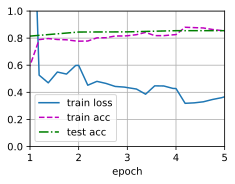

In [12]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

正如我们所看到的，微调模型在相同的历时中往往表现更好，因为其初始参数值更有效。

##**14.3. 目标检测和边界框（Object Detection and Bounding Boxes）**

在前面的一些章节中，我们介绍了诸多用于图像分类的模型。在图像分类任务里，我们假设图像里只有一个主体目标，并关注如何识别该目标的类别。然而，很多时候图像里有多个我们感兴趣的目标，我们不仅想知道它们的类别，还想得到它们在图像中的具体位置。在计算机视觉里，我们将这类任务称为 **目标检测（*object detection*）** 或物体检测。

目标检测在多个领域中被广泛使用。例如，在无人驾驶里，我们需要通过识别拍摄到的视频图像里的车辆、行人、道路和障碍的位置来规划行进线路。机器人也常通过该任务来检测感兴趣的目标。安防领域则需要检测异常目标，如歹徒或者炸弹。

In [12]:
%matplotlib inline
import torch
from d2l import torch as d2l

我们将加载本节中要使用的样本图像。我们可以看到，图像的左边有一只狗，右边有一只猫。它们是该图像中的两个主要物体。

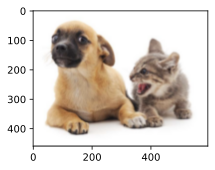

In [19]:
d2l.set_figsize()
img = d2l.plt.imread('/content/catdog.jpg')
d2l.plt.imshow(img);

###**14.3.1. 边界框（Bounding Boxes）**

在目标检测里，我们通常使用 **边界框（*bounding box*）** 来描述目标位置。边界框是一个矩形框，可以由矩形左上角的 $x$ 和 $y$ 轴坐标与右下角的 $x$ 和 $y$ 轴坐标确定。我们根据上面的图的坐标信息来定义图中狗和猫的边界框。图中的坐标原点在图像的左上角，原点往右和往下分别为 $x$ 轴和 $y$ 轴的正方向。

在这里，我们定义了在这两种表现形式之间进行转换的函数：`box_corner_to_center` 从两角表现形式转换为中心-宽度-高度表现形式，`box_center_to_corner` 反之亦然。输入的参数应该是一个二维的张量，其形状为 $(n,4)$，其中 $n$ 是边界框的数量。

In [20]:
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

我们将根据坐标信息来定义狗和猫在图像中的边界框。图像中坐标的原点是图像的左上角，向右和向下分别是  $x$ 轴和 $y$ 轴的正方向。

In [61]:
# Here `bbox` is the abbreviation for bounding box
dog_bbox, cat_bbox = [40.0, 35.0, 308.0, 420.0], [328.0, 92.0, 535.0, 403.0]

我们可以通过两次转换来验证这两个边界盒转换函数的正确性。

In [62]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

让我们在图像中画出边界框，检查它们是否准确。在绘制之前，我们将定义一个辅助函数`bbox_to_rect`。它以 `matplotlib` 包的边界框格式表示边界框。

In [63]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

在图像上添加边界框后，我们可以看到，两个物体的主要轮廓基本上都在两个框内。

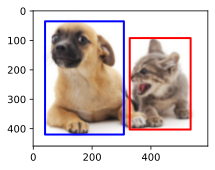

In [64]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));